In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/features_full.parquet"

In [2]:
# before demand estimation, look at the per-category watch ratio distribution

# Load only what we need
df = pd.read_parquet(PATH).copy()

# Normalize "unknown" → "-124" (keep as strings for easy matching)
df["cat"] = df["i_top_category_id"].astype(str).str.strip().str.lower().replace({"unknown": "-124"})

# Top-N categories by interaction count (across full dataset)
top_counts = (
    df["cat"].value_counts()
    .sort_values(ascending=False)
)
top10 = top_counts.head(10).index.tolist()
print("Top 10 categories by interactions:", top10)

# Bins like your p2 figure: 0.0, 0.1, ..., 5.0, and "5.0+"
bins = np.append(np.round(np.arange(0.0, 5.0 + 0.1, 0.1), 1), np.inf)
bin_labels = [f"{x:.1f}" for x in bins[:-2]] + ["5.0+"]  # show 0.0..4.9, then 5.0+

def plot_wr_dist_for_categories(df, categories, title_prefix="Watch-ratio distribution"):
    """
    For each category in `categories` (strings), plot a single-bar chart of
    watch_ratio fractions in 0.1 bins with a 5.0+ tail, using the full dataset.
    """
    for cid in categories:
        s = df.loc[df["cat"] == cid, "watch_ratio"].dropna()
        # bin and get fractions
        binned = pd.cut(s, bins=bins, right=False, include_lowest=True, labels=bin_labels)
        frac = binned.value_counts(normalize=True, sort=False).reindex(bin_labels, fill_value=0.0)

        plt.figure(figsize=(12, 4))
        plt.bar(frac.index, frac.values)
        plt.title(f"{title_prefix} — category {cid} (n={len(s):,})")
        plt.xlabel("Watch ratio bin")
        plt.ylabel("Fraction of interactions")
        plt.xticks(rotation=75, ha="right")
        plt.tight_layout()
        plt.show()

# Example usage:
# 1) Plot for the auto-selected top 10 categories
#plot_wr_dist_for_categories(df, top10)

# 2) Or pick specific categories (strings), e.g.:
# plot_wr_dist_for_categories(df, ["28", "8", "6"])


Top 10 categories by interactions: ['28', '8', '6', '34', '5', '7', '1', '12', '11', '26']


In [3]:
# replace category "unknown" with -124

import pandas as pd
import numpy as np

col = "i_top_category_id"

# Replace "unknown" with -124 while preserving the column's dtype
if isinstance(df[col].dtype, pd.CategoricalDtype):
    # decide whether categories are numeric or string-like
    cat_dtype = df[col].cat.categories.dtype
    target_val = -124 if np.issubdtype(cat_dtype, np.number) else "-124"

    # mask all textual "unknown" (any case/whitespace)
    mask = df[col].astype(str).str.strip().str.lower().eq("unknown")

    # make sure target exists as an allowed category
    if target_val not in df[col].cat.categories.tolist():
        df[col] = df[col].cat.add_categories([target_val])

    # set and then drop the "unknown" category if present
    df.loc[mask, col] = target_val
    try:
        df[col] = df[col].cat.remove_categories(["unknown"])
    except (ValueError, TypeError):
        # category label type may not match exactly; safe to ignore
        pass
else:
    # non-categorical: simple replace; dtype (e.g., object) is preserved
    mask = df[col].astype(str).str.strip().str.lower().eq("unknown")
    df.loc[mask, col] = -124


In [4]:
# Get category list while preserving dtype

# category 30 is missing
if isinstance(df[col].dtype, pd.CategoricalDtype):
    cats = df[col].cat.categories.tolist()
else:
    cats = sorted(pd.unique(df[col].dropna()).tolist())

K = len(cats)
print(f"K = {K}")
print("Categories:", cats)

K = 39
Categories: ['-124', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '5', '6', '7', '8', '9']


In [5]:
# variance of watch ratio per category

# B1 only
b1 = df[df["burst_id"] == 1].copy()

# use the string category col you already made ("cat"); fall back to id if needed
cat_col = "cat" if "cat" in b1.columns else "i_top_category_id"

# drop NaNs
b1 = b1[[cat_col, "watch_ratio"]].dropna()

# sample variance by category (ddof=1). Also include count and mean for context.
wr_stats = (
    b1.groupby(cat_col)["watch_ratio"]
      .agg(count="size", mean="mean", var=lambda x: x.var(ddof=1))
      .reset_index()
      .sort_values("var", ascending=False)
)
wr_stats = wr_stats.reset_index(drop=True)

print(wr_stats)
# If you want ascending:
# print(wr_stats.sort_values("var").head(20))


     cat   count      mean        var
0     38    1586  1.417462  42.048684
1     18   26030  1.196851   4.936585
2      7   68112  1.113612   4.264750
3     28  520405  1.069139   3.805041
4     29   24701  0.830873   3.697870
5     25   90490  1.042262   3.248224
6     11  120117  1.015770   3.235680
7      5   87368  1.220200   3.151888
8     33   37416  0.986547   3.131614
9     34  132858  1.041776   2.927432
10    35   10633  1.027338   2.805881
11    17   66488  1.020954   2.792700
12     8  141171  1.282324   2.630618
13    24     602  1.652716   2.561935
14    16   12502  0.845339   2.533462
15    26   46876  1.028045   2.508040
16    19   49730  0.907540   2.498262
17    37    4500  1.076199   2.489751
18     6  126844  0.903420   2.394166
19    31   36804  1.082917   2.367051
20     9  110538  0.812174   2.328938
21    36    5625  0.863664   2.258458
22    23    7901  1.216016   2.207645
23    13   18726  1.121868   2.173005
24     4   31643  0.959317   2.053900
25    39    

In [6]:
import pandas as pd

# B1 only
b1 = df[df["burst_id"] == 1].copy()

# freeze the B1 category universe (as strings, after your unknown→-124 normalization)
all_cats = sorted(b1["i_top_category_id"].astype(str).unique().tolist())

# per-user seen categories
user_seen = (
    b1.groupby("user_id")["i_top_category_id"]
      .apply(lambda s: sorted(s.astype(str).unique().tolist()))
      .reset_index(name="seen_cats")
)

# counts + unseen lists
user_seen["seen_count"]   = user_seen["seen_cats"].apply(len)
user_seen["unseen_cats"]  = user_seen["seen_cats"].apply(lambda lst: [c for c in all_cats if c not in lst])
user_seen["unseen_count"] = user_seen["unseen_cats"].apply(len)
user_seen["unseen_ratio"] = user_seen["unseen_count"] / len(all_cats)

# (optional) pretty column order
cols = ["user_id", "seen_count", "unseen_count", "unseen_ratio", "seen_cats", "unseen_cats"]
user_table = user_seen[cols].sort_values(["unseen_count", "user_id"], ascending=[False, True]).reset_index(drop=True)

# user_table now has one row per user with unseen categories info.
user_table.tail(10)

,user_id,seen_count,unseen_count,unseen_ratio,seen_cats,unseen_cats
7031,3580,38,1,0.025641,"[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2,...",[-124]
7032,3703,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[38]
7033,3752,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[24]
7034,4376,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[24]
7035,4955,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[29]
7036,5721,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[24]
7037,5812,38,1,0.025641,"[1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2,...",[-124]
7038,6036,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[39]
7039,6282,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[3]
7040,6981,38,1,0.025641,"[-124, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",[24]


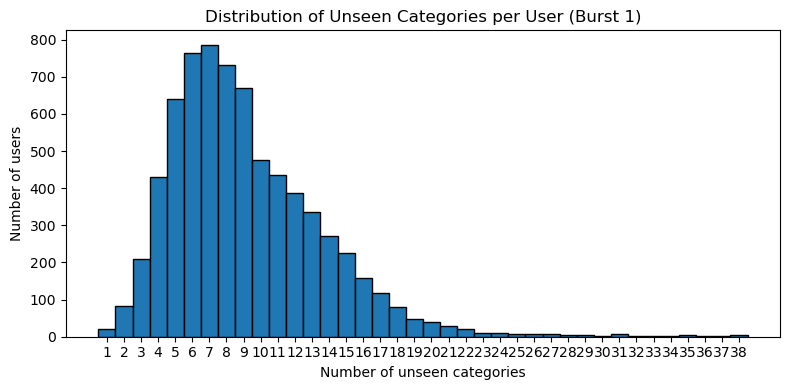

Users: 7041 | mean=9.16, median=8, min=1, max=38


In [7]:
import matplotlib.pyplot as plt

# Histogram of number of unseen categories per user
counts = user_table["unseen_count"]

plt.figure(figsize=(8, 4))
plt.hist(counts, bins=range(int(counts.min()), int(counts.max()) + 2), edgecolor="black", align="left")
plt.title("Distribution of Unseen Categories per User (Burst 1)")
plt.xlabel("Number of unseen categories")
plt.ylabel("Number of users")
plt.xticks(range(int(counts.min()), int(counts.max()) + 1))
plt.tight_layout()
plt.show()

# (optional) quick summary stats
print(
    f"Users: {len(counts)} | "
    f"mean={counts.mean():.2f}, median={counts.median():.0f}, "
    f"min={counts.min()}, max={counts.max()}"
)


In [8]:
# filter D5-D9 from burst 1

# Start from burst 1
b1 = df[df["burst_id"] == 1].copy()

# Pick a datetime column
dtcol = "ts" if ("ts" in b1.columns and pd.api.types.is_datetime64_any_dtype(b1["ts"])) else "timestamp"

# Ensure datetime
if dtcol == "timestamp":
    # convert epoch seconds → UTC datetime
    b1["ts"] = pd.to_datetime(pd.to_numeric(b1["timestamp"], errors="coerce"), unit="s", origin="unix", utc=True)
else:
    b1["ts"] = b1["ts"]  # already datetime

# Build B1 day index
b1["b1_date"] = (b1["ts"].dt.tz_convert(None).dt.date
                 if getattr(b1["ts"].dt, "tz", None) is not None
                 else b1["ts"].dt.date)

dates = sorted(b1["b1_date"].dropna().unique().tolist())
day_map = {d: i+1 for i, d in enumerate(dates)}
b1["day_idx_b1"] = b1["b1_date"].map(day_map).astype("Int16")

# Filter to D5–D9
b1 = b1[b1["day_idx_b1"].between(5, 9)].copy()

print("Rows after D5–D9 filter:", len(b1))
print(b1[["user_id","session","b1_date","day_idx_b1"]].head())


Rows after D5–D9 filter: 1431613
     user_id  session     b1_date  day_idx_b1
215        0       11  2020-07-08           5
216        0       11  2020-07-08           5
217        0       11  2020-07-08           5
218        0       11  2020-07-08           5
219        0       11  2020-07-08           5


In [9]:
# Table: per-user summary in D5–D9 (Burst 1)
# - n_sessions
# - total_exposures
# - exposures by category (one column per category)

import pandas as pd
import numpy as np

def per_user_table_d5d9(df):
    # 1) Burst 1, make a date/day index using ts if present (otherwise convert timestamp)
    b1 = df[df["burst_id"] == 1].copy()
    if "ts" in b1.columns and pd.api.types.is_datetime64_any_dtype(b1["ts"]):
        b1["ts"] = b1["ts"]
    else:
        b1["ts"] = pd.to_datetime(pd.to_numeric(b1["timestamp"], errors="coerce"),
                                  unit="s", origin="unix", utc=True)
    b1["b1_date"] = (b1["ts"].dt.tz_convert(None).dt.date
                     if getattr(b1["ts"].dt, "tz", None) is not None
                     else b1["ts"].dt.date)
    dates = sorted(b1["b1_date"].dropna().unique().tolist())
    day_map = {d: i+1 for i, d in enumerate(dates)}
    b1["day_idx_b1"] = b1["b1_date"].map(day_map).astype("Int16")

    # 2) Keep D5–D9
    b = b1[b1["day_idx_b1"].between(5, 9)].copy()

    # 3) category as string; unify "unknown" -> "-124"
    b["cat"] = b["i_top_category_id"].astype(str).str.strip().str.lower().replace({"unknown": "-124"})
    cats = sorted(b["cat"].unique().tolist())

    # 4) base per-user aggregates
    users = b.groupby("user_id")
    base = pd.DataFrame({
        "n_sessions": users["session"].nunique(),
        "total_exposures": users.size()
    }).reset_index()

    # 5) exposures-by-category (wide)
    by_cat = (b.groupby(["user_id", "cat"]).size()
                .unstack(fill_value=0)
                .reindex(columns=cats, fill_value=0))
    # nice column names
    by_cat.columns = [f"cat::{c}" for c in by_cat.columns]
    by_cat = by_cat.reset_index()

    # 6) merge
    out = base.merge(by_cat, on="user_id", how="left")

    # optional: sort users by total_exposures desc
    out = out.sort_values("total_exposures", ascending=False).reset_index(drop=True)
    return out

# ---- run it (assumes your full dataset is in `df`) ----
user_tbl = per_user_table_d5d9(df)

# peek
user_tbl

# (optional) save
# user_tbl.to_parquet("/path/to/user_summary_D5D9.parquet", index=False)
# user_tbl.to_csv("/path/to/user_summary_D5D9.csv", index=False)


,user_id,n_sessions,total_exposures,cat::-124,cat::1,cat::10,cat::11,cat::12,cat::13,cat::14,...,cat::36,cat::37,cat::38,cat::39,cat::4,cat::5,cat::6,cat::7,cat::8,cat::9
0,3133,25,2640,0,248,135,34,6,0,2,...,0,0,0,0,262,21,231,0,24,106
1,1092,20,1050,0,49,83,89,26,10,0,...,1,1,0,0,2,20,47,19,16,81
2,4215,8,837,1,28,16,46,27,8,3,...,3,3,0,0,9,26,25,37,67,42
3,1657,8,717,1,10,26,36,16,3,6,...,2,2,0,2,10,16,42,25,52,23
4,4731,10,716,1,23,12,31,13,2,3,...,2,1,0,2,12,44,37,24,76,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024,475,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7025,6972,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7026,4109,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7027,4255,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


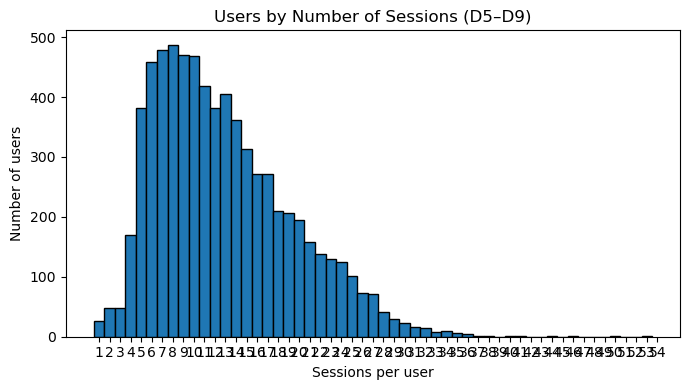

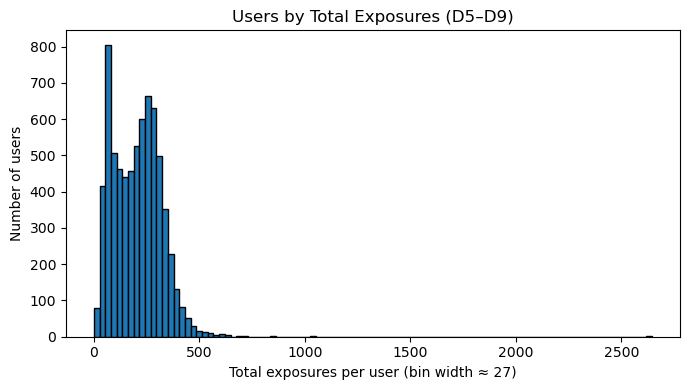

Sessions per user summary:
 count    7029.000000
mean       12.841229
std         6.469697
min         1.000000
25%         8.000000
50%        12.000000
75%        17.000000
max        53.000000 

Total exposures per user summary:
 count    7029.000000
mean      203.672357
std       114.838863
min         1.000000
25%       104.000000
50%       207.000000
75%       283.000000
max      2640.000000


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays
s = user_tbl["n_sessions"].to_numpy()
e = user_tbl["total_exposures"].to_numpy()

# ---------- Histogram: number of sessions per user (integer bins) ----------
bins_s = np.arange(s.min(), s.max() + 2)  # integer bin edges
plt.figure(figsize=(7,4))
plt.hist(s, bins=bins_s, align="left", edgecolor="black")
plt.title("Users by Number of Sessions (D5–D9)")
plt.xlabel("Sessions per user")
plt.ylabel("Number of users")
plt.xticks(bins_s)
plt.tight_layout()
plt.show()

# ---------- Histogram: total exposures per user ----------
# Auto step so we get ~30 bins; clamp to at least 50
step = max(20, int(np.ceil((e.max() - e.min()) / 100.0)))
bins_e = np.arange(0, e.max() + step, step)

plt.figure(figsize=(7,4))
plt.hist(e, bins=bins_e, edgecolor="black")
plt.title("Users by Total Exposures (D5–D9)")
plt.xlabel(f"Total exposures per user (bin width ≈ {step})")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

# ---- Quick summaries (optional) ----
print("Sessions per user summary:\n", user_tbl["n_sessions"].describe().to_string(), "\n")
print("Total exposures per user summary:\n", user_tbl["total_exposures"].describe().to_string())

# ---- If you prefer fixed wide bins for exposures (e.g., 0–500, 500–1000, …), use this instead:
# bins_e_fixed = np.array([0, 500, 1000, 2000, 5000, 10000, np.inf], dtype=float)
# labels = [f"{int(bins_e_fixed[i])}-{int(bins_e_fixed[i+1])-1}" if np.isfinite(bins_e_fixed[i+1]) else f"{int(bins_e_fixed[i])}+"
#           for i in range(len(bins_e_fixed)-1)]
# binned = pd.cut(user_tbl["total_exposures"], bins=bins_e_fixed, right=False, labels=labels)
# ax = binned.value_counts().reindex(labels, fill_value=0).plot(kind="bar", figsize=(8,4), edgecolor="black")
# ax.set_title("Users by Total Exposures (D5–D9) — Fixed Bins")
# ax.set_xlabel("Total exposures per user")
# ax.set_ylabel("Number of users")
# plt.tight_layout(); plt.show()


In [11]:
# === Estimation for USER 1 (Burst 1), using seen–set weighted-mean-zero and unseen μ=0 ===
# Inputs assumed available in memory:
#   b1   : raw interactions DataFrame for burst 1 (has user_id, session, i_top_category_id, watch_ratio, y_complete)
#   out  : beliefs DataFrame you saved earlier (user_id, session_id, burst_id, date, and 39 "cat::<id>" columns)
#
# What this does:
#   1) builds per-session counts N_{t,k}, M_{t,k} for user 1
#   2) fixes σ_k^2 to the user’s watch_ratio variance per category (with a small floor)
#   3) enforces seen-set weighted-mean-zero for μ (weights = exposure shares across D5–D9/B1 data you pass in b1)
#   4) fixes unseen μ_k = 0
#   5) estimates μ_seen and c>0 by maximizing the binomial log-likelihood
#
# NOTE: If you only want days D5–D9, pre-filter b1 to those sessions before running this cell.

import numpy as np
import pandas as pd

# ---------- 0) Select USER 1 data, prep categories and beliefs ----------
uids_b1 = b1["user_id"].unique()
uid = uids_b1[0]  # "first user" in this slice
df_u = b1.loc[b1["user_id"] == uid, ["user_id","session","i_top_category_id","watch_ratio","y_complete","timestamp"]].copy()


# Load beliefs (B1) so `out` exists
BELIEF_PATH = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_beliefs.parquet"
out = pd.read_parquet(BELIEF_PATH)

# (optional) keep only burst 1 to be safe
out = out[out["burst_id"] == 1].copy()

# Belief columns (39 categories) for later use
bel_cols = [c for c in out.columns if c.startswith("cat::")]

# category universe (strings), ordered to match belief columns in `out`
bel_cols = [c for c in out.columns if c.startswith("cat::")]
cats = [c.split("cat::",1)[1] for c in bel_cols]          # e.g., ['1','2',...,'-124']
K = len(cats)
cat2idx = {c:i for i,c in enumerate(cats)}

# merge beliefs for this user on session
bel_u = out.loc[(out["user_id"] == uid) & (out["burst_id"] == 1), ["user_id","session_id"] + bel_cols].copy()
bel_u = bel_u.rename(columns={"session_id":"session"})

# keep overlap sessions only
df_u = df_u.merge(bel_u[["user_id","session"]], on=["user_id","session"], how="inner")

In [12]:
# ---------- 1) Build per-session per-category counts: N_{t,k}, M_{t,k} ----------
# Use provided y_complete if available; otherwise derive from watch_ratio (e.g., >=1.0) — here we prefer y_complete.
if "y_complete" not in df_u.columns or df_u["y_complete"].isna().all():
    df_u["y_complete"] = (df_u["watch_ratio"] >= 1.0).astype("int8")

# session order
sess_order = (
    df_u.groupby("session", as_index=False)["timestamp"].min()
        .sort_values("timestamp")["session"].tolist()
)

# build N and M matrices aligned to `sess_order` and `cats`
S = len(sess_order)
N = np.zeros((S, K), dtype=np.int32)
M = np.zeros((S, K), dtype=np.int32)

for s_idx, sid in enumerate(sess_order):
    g = df_u.loc[df_u["session"] == sid, ["i_top_category_id","y_complete"]]
    # counts
    vc = g["i_top_category_id"].astype(str).value_counts()
    for c_str, cnt in vc.items():
        if c_str in cat2idx:
            N[s_idx, cat2idx[c_str]] = int(cnt)
    # completions
    gm = g.loc[g["y_complete"] == 1, "i_top_category_id"].astype(str).value_counts()
    for c_str, cnt in gm.items():
        if c_str in cat2idx:
            M[s_idx, cat2idx[c_str]] = int(cnt)

# beliefs per session (rows aligned to sess_order, columns aligned to cats)
P = (
    bel_u.set_index("session")
         .loc[sess_order, bel_cols]
         .to_numpy(dtype=float)
)

In [13]:
# ---------- 2) Fix σ_k^2 from user’s WR variance per category (with small floor) ----------
wr_var = (
    df_u.assign(cat=df_u["i_top_category_id"].astype(str))
        .groupby("cat")["watch_ratio"].var(ddof=1)
        .reindex(cats).fillna(0.0).to_numpy()
)
sigma = np.sqrt(np.maximum(wr_var, 1e-4))   # floor for stability

sigma

array([0.97483285, 0.63601039, 0.01      , 0.01      , 0.44357865,
       0.51706241, 1.16243545, 1.0260558 , 0.7303303 , 0.63529669,
       0.71748641, 0.62321817, 0.01      , 0.01      , 0.85332439,
       0.01      , 1.46522438, 2.89378285, 0.66763203, 0.2911217 ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.89974901,
       0.4437165 , 0.01      , 0.91307423, 0.01      , 0.76316487,
       0.22440346, 0.01      , 0.74363048, 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      ])

In [14]:
# ---------- 3) Seen set S_i and weights w_{i,k} (exposure shares) ----------
N_total_by_cat = N.sum(axis=0)
seen_mask = N_total_by_cat > 0  ######### mask the insufficent-exposure category
seen_idx = np.where(seen_mask)[0]
unseen_idx = np.where(~seen_mask)[0]

w = np.zeros(K, dtype=float)
if seen_idx.size > 0:
    w_seen = N_total_by_cat[seen_idx].astype(float)
    w_seen = w_seen / w_seen.sum()
    w[seen_idx] = w_seen

In [15]:
# ---------- 4) Helper: compute τ_t given μ (K,) and c>0 via 1D root-finding ----------
import numpy as np

def _phi(z):  # standard normal pdf (vectorized)
    return np.exp(-0.5 * z * z) / np.sqrt(2.0 * np.pi)

def _Q(z):
    """
    Upper tail 1 - Φ(z), vectorized, no scipy/np.erfc required.
    Uses Abramowitz–Stegun 7.1.26 erf approximation (max error ~1.5e-7).
    """
    x = z / np.sqrt(2.0)
    t = 1.0 / (1.0 + 0.3275911 * np.abs(x))
    a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
    # erf approximation
    poly = (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t
    erf_approx = 1.0 - poly * np.exp(-x * x)
    erf_approx = np.where(x >= 0, erf_approx, -erf_approx)
    Phi = 0.5 * (1.0 + erf_approx)
    return 1.0 - Phi


def solve_tau_for_session(mu, c, p_row, sig):
    """
    Solve (1 - F(τ)) * (E[u|u>τ] - τ) = c  for a single session.
    mu, p_row, sig: arrays of length K
    """
    # bracket for τ: [lo, hi]
    lo = (mu - 6*sig).min() - 2.0
    hi = (mu + 6*sig).max() + 2.0

    def g(tau):
        z = (tau - mu) / sig
        Q = _Q(z)                # (K,)
        num = (mu*Q + sig*_phi(z)) @ p_row
        den = (Q @ p_row) + 1e-15
        tail = den
        E_trunc = num / den
        return tail * (E_trunc - tau) - c

    # expand if sign doesn't change
    g_lo, g_hi = g(lo), g(hi)
    it = 0
    while g_lo * g_hi > 0 and it < 8:
        # expand symmetrically
        span = hi - lo
        lo -= span
        hi += span
        g_lo, g_hi = g(lo), g(hi)
        it += 1

    # bisection
    for _ in range(80):
        mid = 0.5*(lo+hi)
        g_mid = g(mid)
        if g_lo * g_mid <= 0:
            hi, g_hi = mid, g_mid
        else:
            lo, g_lo = mid, g_mid
    return 0.5*(lo+hi)


In [16]:
# ---------- 5) Log-likelihood given θ = (μ_free, log_c) with built-in constraint ----------
# Enforce seen-set weighted-mean-zero by re-centering μ at every evaluation:
#   μ = μ_tilde - (sum_k w_k μ_tilde_k) * 1_seen
# Unseen μ_k are fixed to 0.

def unpack_params(theta):
    # theta = [μ_tilde for seen_idx ..., log_c]
    mu_tilde = np.array(theta[:-1])
    log_c = theta[-1]
    c = np.exp(log_c)

    mu = np.zeros(K, dtype=float)
    mu[seen_idx] = mu_tilde

    # center on seen set with weights w
    offset = (w[seen_idx] * mu_tilde).sum()  # ∑_seen w_k μ_tilde_k
    mu[seen_idx] = mu_tilde - offset         # imposes ∑ w_k μ_k = 0 over seen
    # unseen remain 0
    return mu, c

def session_loglike(mu, c, p_row, N_row, M_row, sig):
    # solve τ for this session
    tau = solve_tau_for_session(mu, c, p_row, sig)
    z = (tau - mu) / sig
    pi_k = _Q(z)
    # clamp for numerical stability
    pi_k = np.clip(pi_k, 1e-8, 1-1e-8)
    # binomial log-likelihood over categories
    ll = (M_row * np.log(pi_k) + (N_row - M_row) * np.log(1 - pi_k)).sum()
    return ll
    
def neg_loglike(theta):
    mu, c = unpack_params(theta)
    ll = 0.0
    for s in range(S):
        ll += session_loglike(mu, c, P[s,:], N[s,:], M[s,:], sigma)
    return -ll
    
# ---- Ridge configuration ----
lambda_ridge = 1e-2     # try 1e-3 … 1e-2; increase if μ’s still explode
N0 = 30                 # exposure pivot; categories with N_k << N0 get stronger shrink

# exposures per category (K,) across the S sessions used for this user
Nk = N.sum(axis=0).astype(float)         # total trials per category
wk = (N0 / (Nk + N0))                    # weights in [~0,1]; small Nk → weight ~1
# only apply to seen categories (unseen μ fixed to 0 already)
wk_seen = wk[seen_idx]
sigma_seen = sigma[seen_idx]

def neg_loglike_ridge(theta):
    """Original NLL + ridge on standardized μ for seen categories, weighted by exposures."""
    base = neg_loglike(theta)
    mu, c = unpack_params(theta)
    mu_seen = mu[seen_idx]
    pen = lambda_ridge * float(np.sum(wk_seen * (mu_seen / (sigma_seen + 1e-12))**2))
    return base + pen


In [17]:
# ---------- 6) Initialize θ and optimize with SciPy L-BFGS-B ----------
import numpy as np
from scipy.optimize import minimize
from time import time 
from itertools import count

# Start with μ_seen = 0; unseen fixed at 0 via unpack_params
mu0 = np.zeros(len(seen_idx), dtype=float)

# c0 from median g_t(0) when μ=0  (Q(0)=0.5, φ(0)=1/√(2π))
phi0 = 1.0 / np.sqrt(2.0 * np.pi)
c_per_sess = phi0 * (P @ sigma)      # shape (S,)
c0 = float(np.clip(np.median(c_per_sess), 1e-3, None))
log_c0 = np.log(c0)

theta0 = np.concatenate([mu0, [log_c0]])

res = minimize(
    fun=neg_loglike_ridge,
    x0=theta0,
    method="L-BFGS-B",
    jac=None,
    options=dict(
        gtol=1e-2,            # stop when ||projected grad|| <= 0.01
        maxiter=10000,       # generous caps so gtol is the active stop
        maxfun=50000,
        disp=True             # prints SciPy's iteration summary
    ),
)

theta_hat = res.x
print("Success:", res.success)
print("Message:", res.message)


Success: True
Message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL


In [18]:
# --- parameters: μ (all K) and c ---
mu_hat, c_hat = unpack_params(theta_hat)          # full K-vector with unseen already set to 0 by construction
print(f"\nEstimated c = {c_hat:.6f}")

param_df = pd.DataFrame({
    "category": cats,
    "seen": [bool(m) for m in seen_mask],
    "mu_hat": mu_hat,
    "sigma": sigma,
    "exposures_total": N.sum(axis=0)
}).sort_values(["seen","category"], ascending=[False, True])
print("\nParameters (first 20 rows):")
print(param_df.head(20).to_string(index=False))

# --- selectivity threshold τ per session ---
tau_hat = np.array([solve_tau_for_session(mu_hat, c_hat, P[s, :], sigma) for s in range(S)])

tau_df = pd.DataFrame({
    "session": [sid for sid in bel_u.set_index("session").loc[sess_order].index],
    "tau": tau_hat,
    "total_exposures": N.sum(axis=1),
    "total_completions": M.sum(axis=1)
})
print("\nSession-level selectivity (τ) — first 10:")
print(tau_df.head(10).to_string(index=False))

# --- optional: predicted per-(session,category) completion probabilities ---
z = (tau_hat[:, None] - mu_hat[None, :]) / sigma[None, :]
pi_pred = np.clip(_Q(z), 1e-8, 1-1e-8)  # S x K matrix
# quick check of fit
obs_rate = np.divide(M, np.maximum(N, 1), where=(N > 0))
mask = N > 0
mae = float(np.mean(np.abs(obs_rate[mask] - pi_pred[mask])))
print(f"\nMAE of per-(session,category) completion rate (seen cells): {mae:.4f}")



Estimated c = 0.328951

Parameters (first 20 rows):
category  seen    mu_hat    sigma  exposures_total
    -124  True  0.004422 0.010000                1
       1  True  0.333461 0.974833                7
      10  True  0.311479 0.635297                4
      11  True -0.192267 0.717486               11
      12  True -0.360746 0.623218                3
      14  True  0.001999 0.010000                1
      15  True  0.030798 0.853324               12
      16  True -0.000557 0.010000                1
      17  True -0.747834 1.465224                5
      18  True -1.338597 2.893783                2
      19  True  0.171904 0.667632                3
       2  True -0.087041 0.636010                2
      20  True  0.544715 0.291122                2
      21  True  0.002664 0.010000                1
      23  True -0.000541 0.010000                1
      25  True -0.168046 0.899749                4
      26  True  0.815128 0.443716                2
      28  True  0.065813 0.91

Top-5 by μ̂:
  category    mu_hat     sigma  exposures_total
0        5  0.842845  0.443579                4
1       26  0.815128  0.443716                2
2       20  0.544715  0.291122                2
3       32  0.468347  0.224403                2
4        1  0.333461  0.974833                7


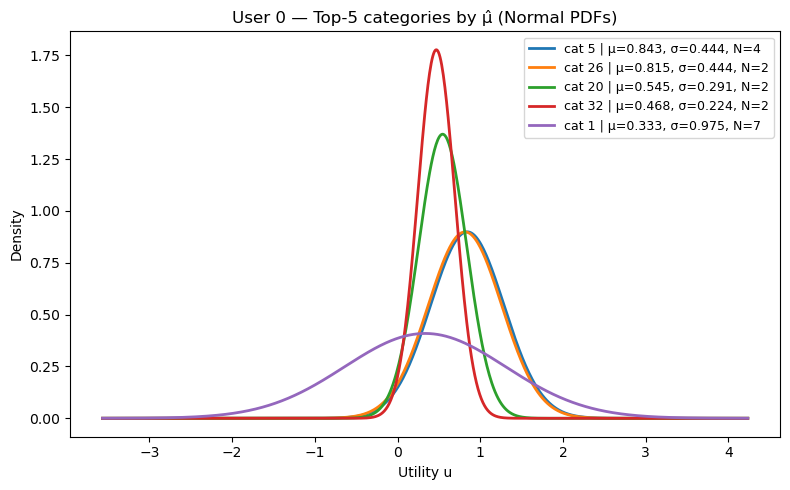

In [19]:
# ----- pick top-5 categories by mean (use param_df which has exposures_total) -----

top5 = (param_df[param_df["seen"]]
        .sort_values("mu_hat", ascending=False)
        .head(5)
        .reset_index(drop=True))

print("Top-5 by μ̂:")
print(top5[["category", "mu_hat", "sigma", "exposures_total"]])

# ----- plot their Normal PDFs on one figure -----
import numpy as np
import matplotlib.pyplot as plt

def normal_pdf(x, mu, sigma):
    sigma = max(float(sigma), 1e-6)
    return np.exp(-0.5*((x - mu)/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

# x-range covering all curves (±4σ around each μ)
x_min = float((top5["mu_hat"] - 4*top5["sigma"]).min())
x_max = float((top5["mu_hat"] + 4*top5["sigma"]).max())
x = np.linspace(x_min, x_max, 800)

plt.figure(figsize=(8,5))
for _, r in top5.iterrows():
    y = normal_pdf(x, r["mu_hat"], r["sigma"])
    lbl = f"cat {r['category']} | μ={r['mu_hat']:.3f}, σ={r['sigma']:.3f}, N={int(r['exposures_total'])}"
    plt.plot(x, y, linewidth=2, label=lbl)

plt.title(f"User {uid} — Top-5 categories by μ̂ (Normal PDFs)")
plt.xlabel("Utility u")
plt.ylabel("Density")
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()


In [20]:
# ====== ESTIMATION FOR (SOME OR ALL) USERS  ======

import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- knobs ---
N_USERS       = None        # None -> all eligible_users
N_MIN_KEEP    = 3
SIGMA_FLOOR   = 0.10
RIDGE_LAMBDA  = 1e-3
RIDGE_N0      = 40
GTOL          = 1e-2      # use the same/tighter than single-user
MAXITER       = 2000
MAXFUN        = 200000
H_MU          = 1e-3      # forward-diff step for μ
H_C           = 1e-2      # forward-diff step for log c
START_JITTER  = 1e-3      # tiny jitter so we don’t sit on a flat spot

# --- helpers used in the single-user code ---
def _phi(z):
    return np.exp(-0.5*z*z) / np.sqrt(2.0*np.pi)

def _Q(z):
    # 1 - Phi(z), vectorized (A&S erf approx)
    x = z / np.sqrt(2.0)
    t = 1.0/(1.0 + 0.3275911*np.abs(x))
    a1,a2,a3,a4,a5 = 0.254829592,-0.284496736,1.421413741,-1.453152027,1.061405429
    poly = (((((a5*t + a4)*t) + a3)*t + a2)*t + a1)*t
    erf_approx = 1.0 - poly*np.exp(-x*x)
    erf_approx = np.where(x>=0, erf_approx, -erf_approx)
    Phi = 0.5*(1.0 + erf_approx)
    return 1.0 - Phi

def solve_tau_for_session(mu, c, p_row, sig):
    lo = (mu - 6*sig).min() - 2.0
    hi = (mu + 6*sig).max() + 2.0
    def g(tau):
        z = (tau - mu)/sig
        Q = _Q(z)
        num = (mu*Q + sig*_phi(z)) @ p_row
        den = (Q @ p_row) + 1e-15
        tail = den
        Etr = num/den
        return tail*(Etr - tau) - c
    g_lo, g_hi = g(lo), g(hi)
    it = 0
    while g_lo*g_hi > 0 and it < 8:
        span = hi-lo; lo -= span; hi += span
        g_lo, g_hi = g(lo), g(hi); it += 1
    for _ in range(80):
        mid = 0.5*(lo+hi); g_mid = g(mid)
        if g_lo*g_mid <= 0: hi, g_hi = mid, g_mid
        else:               lo, g_lo = mid, g_mid
    return 0.5*(lo+hi)

def make_user_mats(df_u, bel_u, cats, sigma_floor=None):
    """
    Build per-user matrices:
      P: beliefs per session (S x K) aligned to `cats`
      N: exposures counts per (session, cat) (S x K)
      M: completions counts per (session, cat) (S x K)
      sigma: per-category std from watch_ratio variance with a floor (K,)
      sess_order: sorted list of session ids used

    Parameters
    ----------
    df_u : pd.DataFrame  (must include columns: session, i_top_category_id, watch_ratio, y_complete)
    bel_u: pd.DataFrame  (must include columns: session, cat::<category> for each belief column)
    cats : list[str]     (category labels matching belief column suffixes)
    sigma_floor : float or None
        If None, uses global SIGMA_FLOOR if defined; else defaults to 0.10.
    """
    import numpy as np
    import pandas as pd

    if sigma_floor is None:
        sigma_floor = globals().get("SIGMA_FLOOR", 0.10)

    # ---- sessions intersection + order ----
    sess_order = sorted(set(df_u["session"]).intersection(set(bel_u["session"])))
    if not sess_order:
        return None, None, None, None, []

    # ---- beliefs → P (S x K) aligned to cats ----
    bel_u = bel_u[bel_u["session"].isin(sess_order)].copy().sort_values("session")
    need_cols = [f"cat::{c}" for c in cats]
    # add any missing belief columns as zeros
    for col in need_cols:
        if col not in bel_u.columns:
            bel_u[col] = 0.0
    P = bel_u[need_cols].to_numpy(dtype=float)

    # ---- restrict df_u to those sessions & normalize category labels ----
    df_u = df_u[df_u["session"].isin(sess_order)].copy()
    df_u["cat"] = (
        df_u["i_top_category_id"]
        .astype(str).str.strip().str.lower()
        .replace({"unknown": "-124"})
    )

    # ---- exposures N: session × cat counts (aligned to cats) ----
    N_tbl = (
        pd.crosstab(df_u["session"], df_u["cat"])
          .reindex(index=sess_order, columns=cats, fill_value=0)
    )
    N = N_tbl.to_numpy(dtype=float)

    # ---- completions M: session × cat sum of y_complete (aligned to cats) ----
    yc = pd.to_numeric(df_u["y_complete"], errors="coerce").fillna(0).astype("int64")
    M_tbl = (
        pd.crosstab(df_u["session"], df_u["cat"], values=yc, aggfunc="sum")
          .reindex(index=sess_order, columns=cats, fill_value=0)
          .fillna(0)
    )
    M = M_tbl.to_numpy(dtype=float)

    # ---- per-category sigma from watch_ratio variance with floor ----
    wr_var = (
        df_u.groupby("cat")["watch_ratio"].var()
            .reindex(cats).fillna(sigma_floor**2)
    )
    sigma = np.sqrt(np.maximum(wr_var.to_numpy(dtype=float), sigma_floor**2))

    # ---- sanity checks ----
    if np.isnan(N).any() or np.isnan(M).any():
        raise ValueError("NaN detected in N or M after construction")
    if (N < 0).any() or (M < 0).any():
        raise ValueError("Negative counts in N or M")
    if (M > N + 1e-12).any():
        r, c = np.argwhere(M > N + 1e-12)[0]
        raise ValueError(
            f"M exceeds N at session={sess_order[int(r)]}, cat={cats[int(c)]}: "
            f"M={M[int(r), int(c)]}, N={N[int(r), int(c)]}"
        )

    return P, N, M, sigma, sess_order



def numerical_grad_fwd(f, theta, h_mu=H_MU, h_c=H_C):
    g = np.zeros_like(theta, float)
    f0 = f(theta); J = len(theta)-1
    for j in range(J):
        thp = theta.copy(); thp[j] += h_mu
        g[j] = (f(thp) - f0)/h_mu
    thp = theta.copy(); thp[-1] += h_c
    g[-1] = (f(thp) - f0)/h_c
    return g
    
def build_b1_D5D9(df):
    b1 = df[df["burst_id"] == 1].copy()
    ts = (b1["ts"] if "ts" in b1.columns and pd.api.types.is_datetime64_any_dtype(b1["ts"])
          else pd.to_datetime(pd.to_numeric(b1["timestamp"], errors="coerce"),
                              unit="s", origin="unix", utc=True))
    b1["b1_date"] = ts.dt.tz_convert(None).dt.date if getattr(ts.dt, "tz", None) is not None else ts.dt.date
    dates = sorted(pd.Series(b1["b1_date"]).dropna().unique().tolist())
    day_map = {d: i+1 for i, d in enumerate(dates)}
    b1["day_idx_b1"] = b1["b1_date"].map(day_map).astype("Int16")
    return b1[b1["day_idx_b1"].between(5, 9)].copy()



# --- beliefs category order (fixed) ---
bel_cols = [c for c in out.columns if c.startswith("cat::")]
cats_fix = [c.split("cat::",1)[1] for c in bel_cols]


# --- build D5–D9 slice (if not already built) ---
# assumes you still have build_b1_D5D9(df) defined; otherwise replace with your own filter
b1 = build_b1_D5D9(df)

# --- load beliefs (Burst 1) if not already loaded ---
BELIEF_PATH = "/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_beliefs.parquet"
out = pd.read_parquet(BELIEF_PATH)
out = out[out["burst_id"] == 1].copy()

# --- pick eligible users (e.g., at least 100 exposures in D5–D9) ---
user_exp = b1.groupby("user_id").size()
eligible_users = user_exp[user_exp >= 100].index.tolist()

print(f"Eligible users = {len(eligible_users)}")

users_to_run = eligible_users if N_USERS is None else eligible_users[:N_USERS]


Eligible users = 5352


In [21]:
def estimate_user(uid, b1, out,
                  N_MIN_KEEP=3, SIGMA_FLOOR=0.10,
                  RIDGE_LAMBDA=1e-3, RIDGE_N0=40,
                  GTOL=1e-2, MAXITER=2000, MAXFUN=200000):
    bel_cols = [c for c in out.columns if c.startswith("cat::")]
    cats = [c.split("cat::",1)[1] for c in bel_cols]

    cols = ["user_id","session","i_top_category_id","watch_ratio","y_complete","timestamp","ts"]
    cols = [c for c in cols if c in b1.columns]
    df_u = b1.loc[b1["user_id"] == uid, cols].copy()
    if df_u.empty: return None, None, None

    bel_u = (out.loc[(out["user_id"] == uid) & (out["burst_id"] == 1),
                     ["user_id","session_id"] + bel_cols]
               .rename(columns={"session_id":"session"}))

    P, N, M, sigma, sess_order = make_user_mats(df_u, bel_u, cats, SIGMA_FLOOR)
    if P is None: return None, None, None
    S, K = P.shape
    Nk = N.sum(axis=0)
    seen_mask = Nk > 0
    keep_mask = (Nk >= N_MIN_KEEP) & seen_mask
    seen_idx = np.where(keep_mask)[0]
    wk_seen = RIDGE_N0 / (Nk[seen_idx] + RIDGE_N0)
    sigma_seen = np.maximum(sigma[seen_idx], SIGMA_FLOOR)

    def unpack(theta):
        mu_full = np.zeros(K); mu_full[seen_idx] = theta[:-1]
        return mu_full, float(np.exp(theta[-1]))

    def sess_nll(mu, c, p, Nrow, Mrow, sig):
        tau = solve_tau_for_session(mu, c, p, sig)
        z = (tau - mu)/sig
        pi = np.clip(_Q(z), 1e-9, 1-1e-9)
        return -np.sum(Mrow*np.log(pi) + (Nrow-Mrow)*np.log(1-pi))

    def nll(theta):
        mu, c = unpack(theta)
        return sum(sess_nll(mu, c, P[s,:], N[s,:], M[s,:], sigma) for s in range(S))

    def nll_ridge(theta):
        base = nll(theta)
        mu, _ = unpack(theta)
        mu_seen = mu[seen_idx]
        pen = RIDGE_LAMBDA * np.sum(wk_seen * (mu_seen/(sigma_seen+1e-12))**2)
        return float(base + pen)

    phi0 = 1/np.sqrt(2*np.pi)
    c0 = float(np.clip(np.median(phi0*(P @ sigma)), 1e-3, None))
    theta0 = np.concatenate([np.zeros(len(seen_idx)), [np.log(c0)]])

    res = minimize(nll_ridge, theta0, method="L-BFGS-B",
                   options=dict(gtol=GTOL, ftol=np.finfo(float).tiny,
                                maxiter=MAXITER, maxfun=MAXFUN, disp=False))
    mu_hat, c_hat = unpack(res.x)
    tau_hat = np.array([solve_tau_for_session(mu_hat, c_hat, P[s,:], sigma) for s in range(S)])

    params = pd.DataFrame({
        "user_id": uid, "category": cats,
        "seen": seen_mask, "kept": keep_mask,
        "mu_hat": mu_hat, "sigma": sigma, "exposures_total": Nk
    })
    taus = pd.DataFrame({
        "user_id": uid, "session": sess_order, "tau": tau_hat,
        "total_exposures": N.sum(axis=1), "total_completions": M.sum(axis=1)
    })
    return params, taus, c_hat


In [22]:
# ===== Parallel estimation with resume (per-user checkpoints) =====
import os, gc
from pathlib import Path
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

# ---------- config ----------
BASE_OUT = Path("/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared")
PARTS_PARAMS = BASE_OUT / "b1_params_parts"
PARTS_TAU    = BASE_OUT / "b1_tau_parts"
PARTS_C      = BASE_OUT / "b1_c_parts"

for d in (PARTS_PARAMS, PARTS_TAU, PARTS_C):
    d.mkdir(parents=True, exist_ok=True)

# choose which users to run this pass (e.g., a slice or all)
subset_users = users_to_run            # e.g., users_to_run[0:500] for a shard

# parallelism
N_JOBS  = -2
VERBOSE = 10

# (Optional) avoid BLAS oversubscription
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
os.environ.setdefault("JOBLIB_TEMP_FOLDER", "/tmp")

def _user_done(uid: int) -> bool:
    """A user is considered done if all 3 part files exist."""
    p_ok = (PARTS_PARAMS / f"user_{uid}.parquet").exists()
    t_ok = (PARTS_TAU    / f"user_{uid}.parquet").exists()
    c_ok = (PARTS_C      / f"user_{uid}.parquet").exists()
    return p_ok and t_ok and c_ok

# filter to remaining users (resume!)
remaining_users = [uid for uid in subset_users if not _user_done(uid)]
print(f"Users requested this pass: {len(subset_users)} | already done: {len(subset_users)-len(remaining_users)} | remaining: {len(remaining_users)}")

def _estimate_and_save(uid: int):
    """
    Run estimate_user for a single uid and write per-user parquet files immediately.
    Safe for parallel execution (one file per user).
    Returns (uid, err) where err is None on success or a string message.
    """
    try:
        # skip if already done (double safety)
        if _user_done(uid):
            return (uid, None)

        out_tuple = estimate_user(uid, b1, out)   # supports (pdf, tdf, c_hat) or (pdf, tdf)
        if out_tuple is None:
            return (uid, "estimate_user returned None")

        if len(out_tuple) == 3:
            pdf, tdf, c_hat = out_tuple
        elif len(out_tuple) == 2:
            pdf, tdf = out_tuple
            # If estimate_user doesn't return c, derive a minimal frame:
            c_hat = np.nan
        else:
            return (uid, f"unexpected return arity: {len(out_tuple)}")

        if (pdf is None) or (tdf is None) or pdf.empty or tdf.empty:
            return (uid, "no overlap or empty result")

        # enforce user_id field for safety
        if "user_id" not in pdf.columns:
            pdf = pdf.assign(user_id=uid)
        if "user_id" not in tdf.columns:
            tdf = tdf.assign(user_id=uid)
        cdf = pd.DataFrame([{"user_id": uid, "c_hat": float(c_hat)}])

        # write per-user parts
        pdf.to_parquet(PARTS_PARAMS / f"user_{uid}.parquet", index=False)
        tdf.to_parquet(PARTS_TAU    / f"user_{uid}.parquet", index=False)
        cdf.to_parquet(PARTS_C      / f"user_{uid}.parquet", index=False)

        return (uid, None)
    except Exception as e:
        return (uid, str(e))

# run in parallel; results are saved per-user on the fly
if remaining_users:
    with Parallel(n_jobs=N_JOBS, backend="loky", verbose=VERBOSE) as parallel:
        results = parallel(delayed(_estimate_and_save)(uid) for uid in remaining_users)

    # quiet teardown to reduce ResourceTracker noise (especially on macOS)
    get_reusable_executor().shutdown(wait=True, kill_workers=True)
    del parallel
    gc.collect()

    # report failures
    failures = [(uid, err) for uid, err in results if err is not None]
    print(f"Finished pass. Success: {len(remaining_users) - len(failures)} | Failures: {len(failures)}")
    if failures[:5]:
        print("Examples of failures (first 5):")
        for uid, err in failures[:5]:
            print(f"  user {uid}: {err}")
else:
    print("Nothing to do — all users in this pass already completed.")

print("Success: All users' estimates are done.")
# ----- optional: consolidate parts into single files (can run anytime) -----
def _consolidate_parts(parts_dir: Path, out_path: Path):
    files = sorted(parts_dir.glob("user_*.parquet"))
    if not files:
        print(f"[consolidate] no parts in {parts_dir}")
        return
    frames = []
    for f in files:
        try:
            frames.append(pd.read_parquet(f))
        except Exception as e:
            print(f"[consolidate] skip {f.name}: {e}")
    if not frames:
        print(f"[consolidate] nothing to write for {parts_dir}")
        return
    big = pd.concat(frames, ignore_index=True)
    big.to_parquet(out_path, index=False)
    print(f"[consolidate] wrote {out_path} (rows={len(big)})")


Users requested this pass: 5352 | already done: 4391 | remaining: 961


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done  24 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-2)]: Done  46 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-2)]: Done  59 tasks      | elapsed:  7.4min
Exception ignored in: <function ResourceTracker.__del__ at 0x106f31bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

Finished pass. Success: 961 | Failures: 0
Success: All users' estimates are done.


In [24]:
# Example consolidation (uncomment if/when you want a single file):
_consolidate_parts(PARTS_PARAMS, BASE_OUT / "b1_user_params.parquet")
_consolidate_parts(PARTS_TAU,    BASE_OUT / "b1_user_tau.parquet")
_consolidate_parts(PARTS_C,      BASE_OUT / "b1_user_c.parquet")

[consolidate] wrote /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_user_params.parquet (rows=208728)
[consolidate] wrote /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_user_tau.parquet (rows=68954)
[consolidate] wrote /Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared/b1_user_c.parquet (rows=5352)
